In [1]:
cd

/Users/keith_tetrad


In [2]:
import pandas as pd
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#pymol stuff
import pymol
from pymol import cmd, stored

# Initialize PyMOL in headless mode
pymol.pymol_argv = ['pymol', '-qc']
pymol.finish_launching()

# Load the structure 6xm4
cmd.fetch("6xm4", "molecule")

 ExecutiveLoad-Detail: Detected mmCIF


Feature has expired.
Feature:       PYMOL_MAIN
Expire date:   01-may-2023
License path:  /Users/keith_tetrad/.pymol/license.lic:/Library/Application Support/Schrodinger/licenses:
FlexNet Licensing error:-10,32


'molecule'

In [4]:
sample_data = pd.read_csv('kw_dms/results/func_effects/averages/4u8c_B1T1-vs-B1T1_+_4u8c_B2T1-vs-B2T1_func_effects.csv')
sasa_data = pd.read_csv('kw_dms/sasa_data.csv')
sasa_data.rename(columns={'Residue Number': 'site'}, inplace=True)

In [5]:
filtered_data = sample_data[
    (sample_data['n_selections'] != 1) &
    (sample_data['times_seen'] >= 3) &
    (sample_data['effect_std'] <= 1.6)
]

In [6]:
sum_site_effect = filtered_data.groupby('site').agg({
    'effect': 'mean',    # averaging up the 'effect' column
    'wildtype': 'first'
}).reset_index()

In [7]:
def get_charge(amino_acid):
    if amino_acid in ['R', 'K', 'H']:
        return 'Positive'
    elif amino_acid in ['D', 'E']:
        return 'Negative'
    else:
        return 'Neutral'

def get_polarity(amino_acid):
    if amino_acid in ['R', 'K', 'H', 'D', 'E', 'S', 'T', 'N', 'Q', 'Y']:
        return 'Polar'
    else:
        return 'Nonpolar'

In [8]:
sum_site_effect['charge_status'] = sum_site_effect['wildtype'].apply(get_charge)
sum_site_effect['polarity'] = sum_site_effect['wildtype'].apply(get_polarity)

In [9]:
#store secondary structure information for each residue

# Initialize a list in the stored namespace
stored.secondary_structures = []

# Iterate over each residue and store its secondary structure in the stored list
cmd.iterate("molecule and name CA", "stored.secondary_structures.append((resi, ss))")

# Print secondary structure for each residue

3826

In [10]:
#formatting
sum_site_effect['site'] = sum_site_effect['site'].str.extract(r'(\d+)').astype(int)
filtered_data['site'] = filtered_data['site'].str.extract(r'(\d+)').astype(int)

/Users/keith_tetrad/opt/anaconda3/envs/pymol_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
# # Assuming 'stored.secondary_structures' contains your PyMOL data
# # Convert to DataFrame
# ss_df = pd.DataFrame(stored.secondary_structures, columns=['site', 'secondary_structure'])

# # Replace the letters with actual secondary structure names
# ss_df['secondary_structure'] = ss_df['secondary_structure'].map({
#     'H': 'Alpha Helix',
#     'S': 'Beta Sheet',
#     'L': 'Loop'
# })

In [12]:
#'stored.secondary_structures' contains your PyMOL data
# Convert to DataFrame
ss_df = pd.DataFrame(stored.secondary_structures, columns=['site', 'secondary_structure'])

# Function to determine secondary structure
def determine_structure(ss):
    if ss == 'H':
        return 'Alpha Helix'
    elif ss == 'S':
        return 'Beta Sheet'
    else:
        return 'Loop'

# Apply the function to each row in the 'secondary_structure' column
ss_df['secondary_structure'] = ss_df['secondary_structure'].apply(determine_structure)

# Convert 'site' to int in ss_df and remove duplicates
ss_df['site'] = ss_df['site'].astype(int)
ss_df.drop_duplicates(subset=['site'], inplace=True)

In [13]:
merged_df = pd.merge(filtered_data, ss_df, on='site')

In [14]:
entry_lookup = merged_df.loc[merged_df['site'] == 1147]
print(entry_lookup)

     site wildtype mutant   effect  effect_std  times_seen  n_selections  \
568  1147        S      A  0.03360     0.03165        11.5             2   
569  1147        S      L  0.02095     0.02772        21.5             2   
570  1147        S      T -0.12020     0.02886        11.5             2   

    secondary_structure  
568                Loop  
569                Loop  
570                Loop  


In [15]:
# Initialize a list in the stored namespace
stored.atom_data = []

# Iterate over each atom and store its chain identifier, residue number, residue name, and atom name
cmd.iterate("molecule", "stored.atom_data.append((chain, resi, resn, name))")

# Create a DataFrame from the stored data
atom_df = pd.DataFrame(stored.atom_data, columns=['chain', 'resi', 'resn', 'name'])

#convert resi to int if its not already
atom_df['resi'] = atom_df['resi'].astype(int)

In [16]:
# Merge atom_df with only the 'effect' column of merged_df
atom_effect = pd.merge(atom_df, merged_df[['site', 'effect']], left_on='resi', right_on='site', how='left')

# Drop the 'site' column after merging
atom_effect.drop('site', axis=1, inplace=True)

# Replace NaN in 'effect' with 0
atom_effect['effect'].fillna(0, inplace=True)

# Display the first few rows of the updated df1
print(atom_effect)

      chain  resi resn name   effect
0         A    14  GLN   CA  0.03195
1         A    14  GLN   CA  0.03932
2         A    14  GLN   CA -0.21560
3         A    14  GLN   CA -0.07898
4         A    14  GLN   CA  0.03838
...     ...   ...  ...  ...      ...
96228     A  1305  NAG   C6  0.00000
96229     A  1305  NAG   O6  0.00000
96230     A  1305  NAG   C7  0.00000
96231     A  1305  NAG   O7  0.00000
96232     A  1305  NAG   C8  0.00000

[96233 rows x 5 columns]


In [17]:
#Optionally, save the updated DataFrame to a file
#atom_effect.to_csv('kw_dms/atom_effect', sep=' ', index=False, header=False)

In [22]:
filtered_with_ss = pd.merge(filtered_data, ss_df, on='site')

In [25]:
filtered_with_accessible = pd.merge(filtered_data, sasa_data, on='site')

In [27]:
print(filtered_with_accessible)

       site wildtype mutant    effect  effect_std  times_seen  n_selections  \
0       100        I      H  0.048840     0.03705        29.0             2   
1       100        I      H  0.048840     0.03705        29.0             2   
2       100        I      H  0.048840     0.03705        29.0             2   
3       100        I      K -0.089520     0.20230        13.5             2   
4       100        I      K -0.089520     0.20230        13.5             2   
...     ...      ...    ...       ...         ...         ...           ...   
11334   999        G      C -0.116500     0.18530         6.5             2   
11335   999        G      C -0.116500     0.18530         6.5             2   
11336   999        G      S  0.004895     0.02627         3.5             2   
11337   999        G      S  0.004895     0.02627         3.5             2   
11338   999        G      S  0.004895     0.02627         3.5             2   

      Residue Identity        SASA      rSASA surfa

In [28]:
# Filter for 'Alpha Helix', 'Beta Sheet', and 'Loop'
alpha_helix = filtered_with_ss[filtered_with_ss['secondary_structure'] == 'Alpha Helix']
alpha_helix['Category'] = 'Alpha Helix'
beta_sheet = filtered_with_ss[filtered_with_ss['secondary_structure'] == 'Beta Sheet']
beta_sheet['Category'] = 'Beta Sheet'
loop = filtered_with_ss[filtered_with_ss['secondary_structure'] == 'Loop']
loop['Category'] = 'Loop'
all_sites = filtered_with_ss.copy()
all_sites['Category'] = 'All Sites'

/Users/keith_tetrad/opt/anaconda3/envs/pymol_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/keith_tetrad/opt/anaconda3/envs/pymol_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/keith_tetrad/opt/anaconda3/envs/pymol_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A val

In [29]:
# filter for surface accessibility
exposed = filtered_with_accessible[filtered_with_accessible['surface_accessibility'] == 'Exposed']
exposed['Category'] = 'Exposed'
burried = filtered_with_accessible[filtered_with_accessible['surface_accessibility'] == 'Burried']
burried['Category'] = 'Burried'

/Users/keith_tetrad/opt/anaconda3/envs/pymol_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/keith_tetrad/opt/anaconda3/envs/pymol_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [30]:
data_for_plotting = pd.concat([ all_sites, alpha_helix, beta_sheet, loop, exposed, burried])

In [31]:
data_for_plotting = data_for_plotting[['Category', 'effect']]

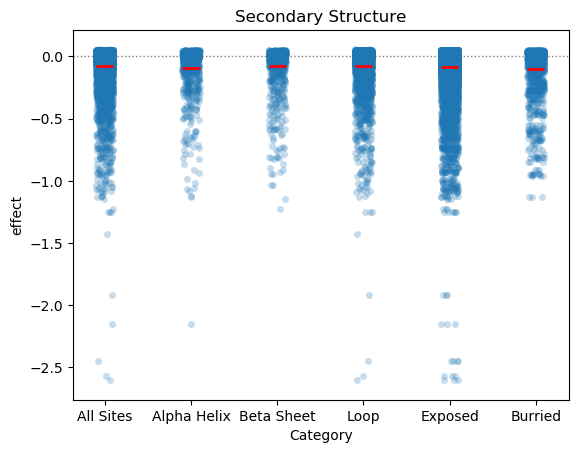

In [32]:
sns.stripplot(x='Category', y='effect', data=data_for_plotting, jitter=True, alpha=0.25)

# Add a horizontal dotted line at y=0
plt.axhline(0, color='grey', linestyle='dotted', linewidth=1)

# Add mean bars for each category
categories = data_for_plotting['Category'].unique()
for i, category in enumerate(categories):
    mean_val = data_for_plotting[data_for_plotting['Category'] == category]['effect'].mean()
    plt.hlines(mean_val, i - 0.1, i + 0.1, colors='red', linewidth=2, zorder=3)

plt.title('Secondary Structure')
plt.show()